In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
#from google.colab import drive
#drive.mount('/content/drive')

### 2 Regularized Logistic Regression

#### 2.1 Visualizing the data

In [3]:
#datafile = '/content/drive/MyDrive/머신러닝/실습2/ex2data2.txt'
datafile = 'ex2data2.txt'
#!head $datafile
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
##Form the usual "X" matrix and "y" vector
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size # number of training examples
##Insert the usual column of 1's into the "X" matrix
X = np.insert(X,0,1,axis=1)

In [4]:
#Divide the sample into two: ones with positive classification, one with null classification
pos = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
neg = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])
#Check to make sure I included all entries
#print "Included everything? ",(len(pos)+len(neg) == X.shape[0])

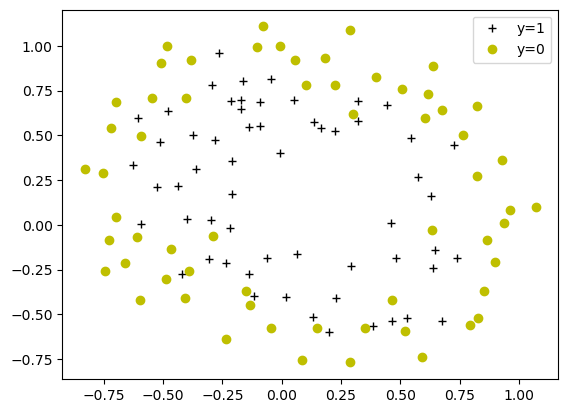

In [5]:
def plotData():
    plt.plot(pos[:,1],pos[:,2],'k+',label='y=1')
    plt.plot(neg[:,1],neg[:,2],'yo',label='y=0')
    plt.legend()


#Draw it square to emphasize circular features
plotData()

#### 2.2 Feature mapping

In [6]:

def mapFeature( x1col, x2col ):
    """ 
    Function that takes in a column of n- x1's, a column of n- x2s, and builds
    a n- x 28-dim matrix of featuers as described in the homework assignment
    """
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out #[1 ,x1, x2, x1^2, x1x2, x2^2, x1^3, x1^2x2, x1x2^2,x2^3,..., x2^6 ]

from sklearn.preprocessing import PolynomialFeatures
# specifying the degree of the polynomial
poly = PolynomialFeatures(degree=6, include_bias=True)

In [7]:
#Create feature-mapped X matrix
mappedX = mapFeature(X[:,1],X[:,2])

In [8]:
print(np.shape(mappedX))

(118, 28)


#### 2.3 Cost function and gradient

In [9]:
def sigmoid(x):
    a = np.exp(-x)
    return 1.0 / (1.0 + a)

In [10]:
def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    Note this includes regularization, if you set mylambda to nonzero
    For the first part of the homework, the default 0. is used for mylambda
    """
    #note to self: *.shape is (rows, columns)
    term1 = np.dot(-np.array(myy).T,np.log(sigmoid(np.dot(myX,mytheta))))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-sigmoid(np.dot(myX,mytheta))))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:])) #Skip theta0
    return float((1./m) * ( np.sum(term1 - term2) + regterm ))

In [11]:
#Cost function is the same as the one implemented above, as I included the regularization
#toggled off for default function call (lambda = 0)
#I do not need separate implementation of the derivative term of the cost function
#Because the scipy optimization function I'm using only needs the cost function itself
#Let's check that the cost function returns a cost of 0.693 with zeros for initial theta,
#and regularized x values
initial_theta = np.zeros((mappedX.shape[1],1))
computeCost(initial_theta,mappedX,y)

0.6931471805599453

##### 2.3.1 Learning parameters using fminunc

In [13]:
#I noticed that fmin wasn't converging (passing max # of iterations)
#so let's use minimize instead

def optimizeRegularizedTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  method='BFGS', options={"maxiter":500, "disp":False} )
    return result
    
result = optimizeRegularizedTheta(initial_theta,mappedX,y)
theta=np.array([result.x])
print(result)

ValueError: 'x0' must only have one dimension.

#### 2.4 Plotting the decision boundary

In [14]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    result= optimizeRegularizedTheta(mytheta,myX,myy,mylambda)
    theta=np.array([result.x])
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

NameError: name 'theta' is not defined

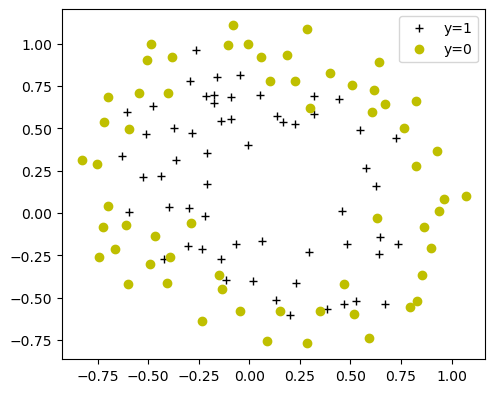

In [15]:
#Build a figure showing contours for various values of regularization parameter, lambda
#It shows for lambda=0 we are overfitting, and for lambda=100 we are underfitting
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1.)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)